#VIRTUAL MACHINE AND ENVIRONMENT

In [ ]:
!sudo apt install virt-manager

In [ ]:
!virt-manager #using gui and ssh to the host kvm

In [ ]:
!virsh edit <vm name> #config the vm using command

In [ ]:
#each vm have one file call volume, the extension of this file are 'qcow2', 'img'. this file contain all configs, environment variables, packages, librarys, codes of OS
#if we copy this file, we create new VM that duplicate from the original file
#the size of the file is the total volume of VM
#to extend the size of os file we using below command
!qemu-img resize name.qcow2 + 45G
#this command extend 45G to the file, if os file is 5G then it will have 50G
#after that we will create new VM by using GUI and this os file

choosing new VM

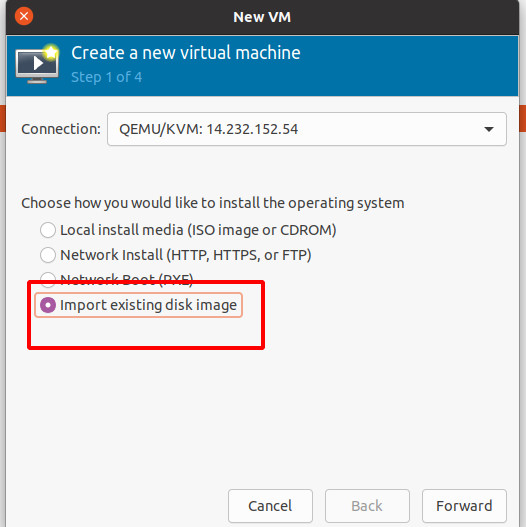

choose the os file that already have been resized
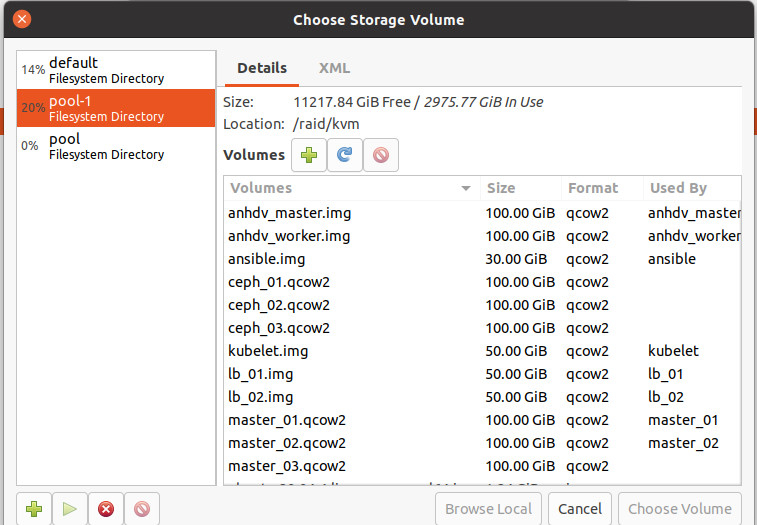

config cpu, ram and then the network interface 

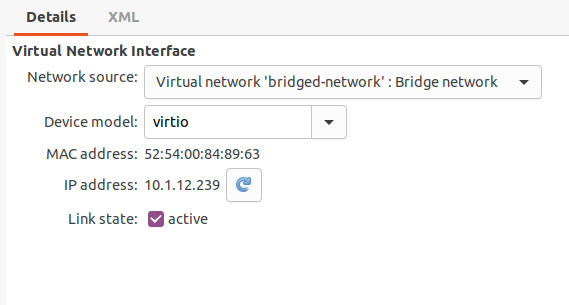

add gpu by using PCIE ID

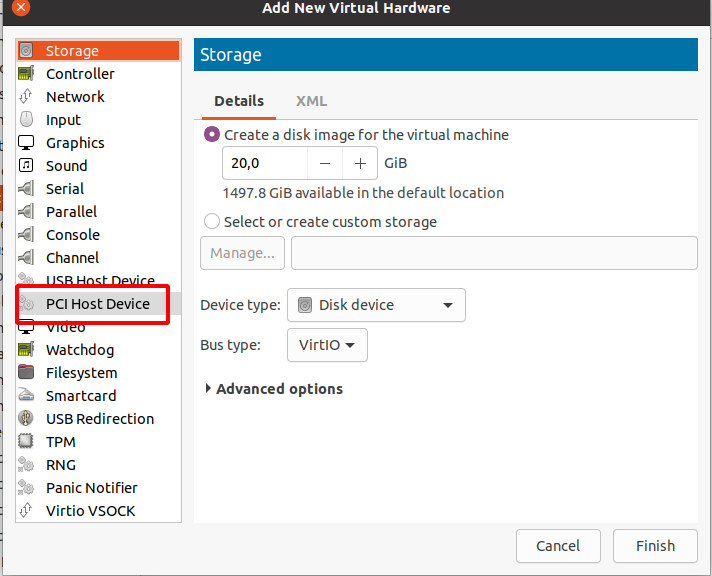

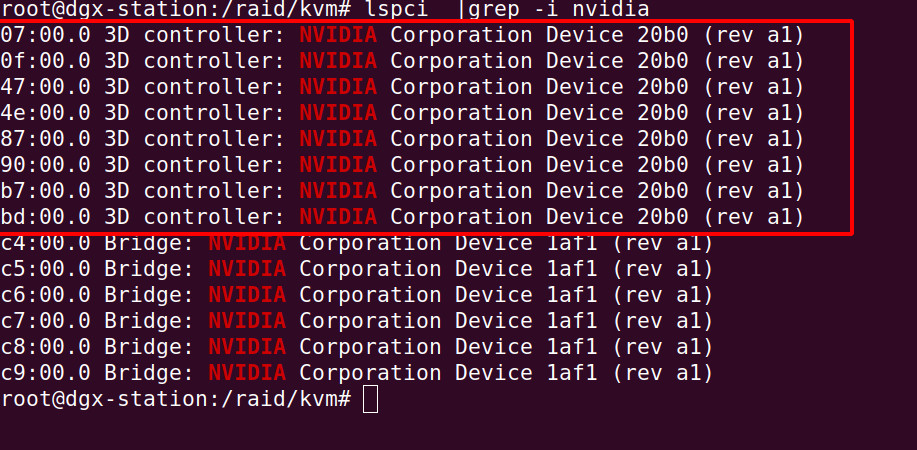

#SETUP KUBERNETES

SETUP NON ROOT USER

In [ ]:
!useradd vkist

In [ ]:
!usermod -aG sudo vkist

In [ ]:
!su vkist

SETUP DOCKER 

CHECK OUT HERE https://docs.docker.com/engine/install/ubuntu/

In [ ]:
!sudo apt-get update
!sudo apt-get install ca-certificates curl gnupg lsb-release

In [ ]:
!curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmor -o /usr/share/keyrings/docker-archive-keyring.gpg

In [ ]:
!echo "deb [arch=$(dpkg --print-architecture) signed-by=/usr/share/keyrings/docker-archive-keyring.gpg] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable" | sudo tee /etc/apt/sources.list.d/docker.list > /dev/null

In [ ]:
!sudo apt-get update
!sudo apt-get install docker-ce docker-ce-cli containerd.io

SET UP KUBEADM, KUBECTL, KUBELET

CHECK OUT HERE  https://kubernetes.io/docs/setup/production-environment/tools/kubeadm/install-kubeadm/

In [ ]:
!sudo apt-get update
!sudo apt-get install -y apt-transport-https ca-certificates curl

In [ ]:
!sudo curl -fsSLo /usr/share/keyrings/kubernetes-archive-keyring.gpg https://packages.cloud.google.com/apt/doc/apt-key.gpg

In [ ]:
!echo "deb [signed-by=/usr/share/keyrings/kubernetes-archive-keyring.gpg] https://apt.kubernetes.io/ kubernetes-xenial main" | sudo tee /etc/apt/sources.list.d/kubernetes.list

In [ ]:
!sudo apt-get update
!sudo apt-get install -y kubelet kubeadm kubectl
!sudo apt-mark hold kubelet kubeadm kubectl

DOWNGRADE OR UPGRADE VERSION OF KUBEADM, KUBECTL, KUBELET

CHECK OUT HERE  https://v1-21.docs.kubernetes.io/docs/tasks/administer-cluster/kubeadm/kubeadm-upgrade/

In [ ]:
!apt-mark unhold kubeadm && \
!apt-get update && apt-get install -y --allow-downgrade kubeadm=1.21.x-00 && \
!apt-mark hold kubeadm

In [ ]:
!apt-get update && \
!apt-get install -y --allow-change-held-packages kubeadm=1.21.x-00

In [ ]:
!apt-mark unhold kubelet kubectl && \
!apt-get update && apt-get install -y --allow-downgrade kubelet=1.21.x-00 kubectl=1.21.x-00 && \
!apt-mark hold kubelet kubectl

In [ ]:
!apt-get update && \
!apt-get install -y --allow-change-held-packages kubelet=1.21.x-00 kubectl=1.21.x-00

In [ ]:
!sudo systemctl daemon-reload
!sudo systemctl restart kubelet

CONFIGURING "cgroups" DRIVER

CHECK OUT HERE  https://kubernetes.io/docs/setup/production-environment/container-runtimes/

In [ ]:
!system status kubelet
!system status docker

In [ ]:
!sudo nano /etc/systemd/system/kubelet.service.d/10-kubeadm.conf
#adding Environment="KUBELET_EXTRA_ARGS=--cgroup-driver=systemd" to this file 

In [ ]:
!sudo nano /lib/systemd/system/docker.service
#adding --exec-opt native.cgroupdriver=systemd after ExecStart command

In [ ]:
!systemctl daemon-reload
!systemctl stop kubelet
!systemctl start kubelet
!systemctl stop docker
!systemctl start docker
!systemctl stop docker.socket
!systemctl start docker.socket

SETUP CONTROL PLANE

In [ ]:
#on master node
!kubeadm reset
!kubeadm init
!kubeadm token create --print-join-command

In [ ]:
#on worker node
#run the command that print out from kubeadm token create --print-join-command
#example
!kubeadm join 10.1.10.137:6443 --token mdet7z.n5wy3qnlgizflw2y --discovery-token-ca-cert-hash sha256:b69e07410fd9fc8c180a4c1683e38eec604d384813156a70773b6a7a6ad84c13

In [ ]:
#on master node
#check that disk space is available
#docker cgroups driver is as the same as kubelet cgroups driver
#turn off the swap memory
!sudo swapoff -a
#move the admin.conf file from /etc to user folder
!sudo cp /etc/kubernetes/admin.conf /home/vkist/.kube/config/admin.conf
!sudo chown vkist:vkist /home/vkist/.kube/config/admin.conf
!export KUBECONFIG=/home/vkist/.kube/config/admin.conf
!kubectl get node

CONTROL AND USING POD

In [ ]:
#on master node 
#to create pods using command kubectl apply -f as non root user
#Firstly, you have to install CNI pod for network to work
#Check out here https://www.weave.works/blog/weave-net-kubernetes-integration/

!kubectl apply -f "https://cloud.weave.works/k8s/net?k8s-version=$(kubectl version | base64 | tr -d '\n')"

In [ ]:
#an example pod
#test_pod.yaml
apiVersion: v1
kind: Pod
metadata:
  name: test-gpu
spec:
  containers:
  - name: test-gpu
    image: nvidia/cuda:11.0-base
    #env:
    #- name: NVIDIA_VISIBLE_DEVICES
    #  value: 0,1
    #securityContext:
    #  capabilities:
    #    add: ['SYS_ADMIN']
    command: ['nvidia-smi', '-L']
    #command: ['echo', '$NVIDIA_VISIBLE_DEVICES']
    resources:
      limits:
        cpu: 8
        nvidia.com/gpu: 1

#to run this pod
!kubectl apply -f test_pod.yaml

In [ ]:
#get all pod 
!kubectl get pod -ALL

In [ ]:
#extend the result
!kubectl get pod -ALL -o wide

In [ ]:
#describe node
!kubectl describe node (<node_name>)

In [ ]:
#get all namspace
!kubectl get all -n <namespace>

In [ ]:
#describe pod
!kubectl describe pod <podname> -n <namespace>

In [ ]:
#logs pod
!kubectl logs <podname> -n <namespace>

In [ ]:
#delete pod
!kubectl delete <podname> -n <namespace>

In [ ]:
#delete the deployment (completely delete the project)
!kubectl delete deployment <deployment> -n <namespace>

INSTALL HELM CHART

CHECK OUT HERE https://helm.sh/docs/intro/install/

helm chart is being used for controling and installing package of project


In [ ]:
#download binary version of helm (3.8.0)
#unpack it (tar -zxvf helm-v3.8.0-linux-amd64.tar.gz)
#find the helm binary in the unpacked directory, and move it to its desired destination (mv linux-amd64/helm /usr/local/bin/helm)

# ENABLE MIG MODE AND SUPPORTED IN KUBERNETES

ENABLE MIG MODE

CHECK OUT HERE  https://docs.nvidia.com/datacenter/tesla/mig-user-guide/

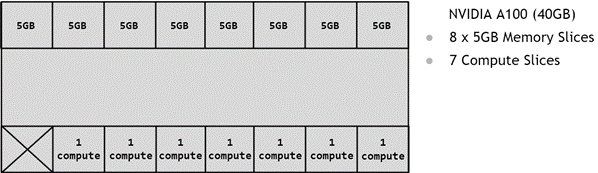

In [ ]:
#check the processes that using gpu and then turn off that all process except nv-fabric
#in case of cannot turn off the processes, you can restart the node
!sudo lsof /dev/nvidia<gpu-id>
#enable mig
!sudo nvidia-smi -i <gpu-id> -mig 1

In [ ]:
#list all mig available
!sudo nvidia-smi mig -lgip

In [ ]:
#create mig instance
!sudo nvidia-smi mig -i <gpu-id> -cgi <mig-id combination> -C 
#example 
!sudo nvidia-smi mig -i 4 -cgi 9,9 -C 

In [ ]:
#list all available device
!sudo nvidia-smi -L

MIG SUPPORT FOR KUBERNETES

CHECK OUT HERE  https://docs.nvidia.com/datacenter/cloud-native/kubernetes/mig-k8s.html

In [ ]:
#on master node
#install k8s-device-plugin and gpu-feature-explorer
!helm repo add nvdp https://nvidia.github.io/k8s-device-plugin
!helm repo add nvgfd https://nvidia.github.io/gpu-feature-discovery
!helm repo update
!helm search repo nvdp --devel
!helm install --version=0.11.0 --generate-name --set migStrategy=mixed nvdp/nvidia-device-plugin
!helm install --version=0.5.0 --generate-name --set migStrategy=mixed nvgfd/gpu-feature-discovery

In [ ]:
#on worker node
#install nvidia-container-runtime and toolkit
#check out here https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html
!curl https://get.docker.com | sh && sudo systemctl --now enable docker
!distribution=$(. /etc/os-release;echo $ID$VERSION_ID) && curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey | sudo gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg && curl -s -L https://nvidia.github.io/libnvidia-container/$distribution/libnvidia-container.list | sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | sudo tee /etc/apt/sources.list.d/nvidia-container-toolkit.list
!curl -s -L https://nvidia.github.io/libnvidia-container/experimental/$distribution/libnvidia-container.list | sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | sudo tee /etc/apt/sources.list.d/nvidia-container-toolkit.list
!sudo apt-get update
!sudo apt-get install -y nvidia-docker2
#test
sudo docker run --rm --gpus all nvidia/cuda:11.0-base nvidia-smi
#set defaut docker runtime to nvidia
sudo nano /etc/docker/daemon.json
#change default-runtime to nvidia
{
    "default-runtime": "nvidia",
    "runtimes": {
        "nvidia": {
            "path": "nvidia-container-runtime",
            "runtimeArgs": []
        }
    }
}
#restart the docker service

In [ ]:
#on master node
#test capacity
!kubectl describe node <gpu-node>

In [ ]:
#privilege access to gpu
#check out here https://docs.google.com/document/d/1zy0key-EL6JH50MZgwg96RPYxxXXnVUdxLZwGiyqLd8/edit#

#PERSISTENT VOLUME AND PERSISTENT VOLUME CLAIM

SET UP NFS SERVER AND NFS CLIENT

CHECK OUT HERE https://xuanthulab.net/su-dung-persistentvolume-nfs-tren-kubernetes.html

In [ ]:
#on nfs server
!sudo apt update
!sudo apt install nfs-kernel-server
!sudo vi /etc/exports
#adding /data/mydata  *(rw,sync,no_subtree_check,insecure)
# make dir
!mkdir -p /data/mydata
!chmod -R 777 /data/mydata
# export and check the config
!exportfs -rav
!exportfs -v
!showmount -e
# restart nfs server
!systemctl stop nfs-server
!systemctl start nfs-server
!systemctl status nfs-server

In [ ]:
#on nfs client
!sudo apt update
!sudo apt install nfs-common
!mkdir /home/data
!mount -t nfs 10.1.8.99:/data/mydata /home/data/
!umount /home/data

CREATE PERSISTENT VOLUME

In [ ]:
#on master node
#pv_nfs.yaml
apiVersion: v1
kind: PersistentVolume
metadata:
  name: pv1 #change name of peristent volume
spec:
  storageClassName: mystorageclass #remove this storage class for automate persistent volume claim
  capacity:
    storage: 5Gi #change storage capacity
  accessModes:
    - ReadWriteOnly
  nfs:
    path: "/data/mydata/" #nfs server shared directory
    server: "10.1.8.99" #nfs server ip

!kubectl apply -f pv_nfs.yaml
#make sure that new pv have created
!kubectl get pv

In [ ]:
#pvc_nfs.yaml
apiVersion: v1
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pvc1 #change persistent volume claim name
spec:
  storageClassName: mystorageclass #remove this storage class for automate persistent volume claim
  accessModes:
    - ReadWriteOnly
  resources:
    requests:
      storage: 5Gi #change storage capacity

!kubectl apply -f pvc_nfs.yaml
#persistent volume claim will automatically find the persistent volume that can provide the requires of it and bound to that persistent volume 
#(have enough capacity and have the same storage class)
#make sure that new pvc have created and bounded to the persistent volume
!kubectl get pvc

#Normally most project will automatically create pvc with no storageclassname so that you have to mannually provide the persistent volume for it to bound
#If you do not create persistent volume for project pvc, some pod will retain on "Pending" status

#SETUP JUPYTERHUB

CHECK OUT HERE https://zero-to-jupyterhub.readthedocs.io/en/latest/jupyterhub/index.html

In [ ]:
#Jupyterhub has 3 component, 
#the hub with spawner to spawn new user notebook pod, 
#the proxy load balancer to deploy service to public IP, 
#the notebook pod that run notebook and user interfaces

#note: we can manually create notebook pod without the hub by using containerized notebook image

#install the simplest version of jupyterhub

!helm repo add jupyterhub https://jupyterhub.github.io/helm-chart/
!helm repo update
!helm upgrade --cleanup-on-fail \
  --install jhub jupyterhub/jupyterhub \
  --namespace jhub \
  --create-namespace \
  --version=1.2.0 \  #change the chart version
  --values config.yaml #create new file config.yaml and run this command in the same directory with this file

In [ ]:
#check the project have installed, wait for the hub and proxy pod to enter the Running state.
!kubectl get pod --namespace jhub

In [ ]:
#check the EXTERNAL-IP and port of proxy-public, the jupyterhub service will serve on this IP:port
!kubectl get service --namespace jhub
#if the EXTERNAL-IP is still in Pending mode, we have to mannually install MetalLB and provide local ip range for proxy-public
#checkout here https://metallb.universe.tf/
!kubectl apply -f https://raw.githubusercontent.com/metallb/metallb/v0.12.1/manifests/namespace.yaml
!kubectl apply -f https://raw.githubusercontent.com/metallb/metallb/v0.12.1/manifests/metallb.yaml
#create metallb.yaml file 
apiVersion: v1
kind: ConfigMap
metadata:
  namespace: metallb-system
  name: config
data:
  config: |
    address-pools:
    - name: default
      protocol: layer2
      addresses:
      - 10.1.12.200-10.1.12.250 #provide local ip range

!kubectl apply -f metallb.yaml

CUSTOMIZE JUPYTERHUB

In [ ]:
#we customize Jupyterhub through config.yaml file, after each time modifying the config.yaml file, we run the helm chart command to upgrade 
!helm upgrade --cleanup-on-fail jhub jupyterhub/jupyterhub --namespace jhub --version=1.2.0 --values config.yaml
!helm list

In [ ]:
#this is the content of config.yaml

# This file can update the JupyterHub Helm chart's default configuration values.
#
# For reference see the configuration reference and default values, but make
# sure to refer to the Helm chart version of interest to you!
#
# Introduction to YAML:     https://www.youtube.com/watch?v=cdLNKUoMc6c
# Chart config reference:   https://zero-to-jupyterhub.readthedocs.io/en/stable/resources/reference.html
# Chart default values:     https://github.com/jupyterhub/zero-to-jupyterhub-k8s/blob/HEAD/jupyterhub/values.yaml
# Available chart versions: https://jupyterhub.github.io/helm-chart/
#

singleuser:
  defaultUrl: "/lab"   #default url to user interface (new interface of jupyter notebook)
  extraEnv:
    JUPYTERHUB_SINGLEUSER_APP: "jupyter_server.serverapp.ServerApp" #default kernel of jupyter notebook
    GRANT_SUDO: "yes" #grant sudo privilege for notebook user jovyan
    NOTEBOOK_ARGS: "--allow-root" #grant sudo privilege for notebook user jovyan
  uid: 0  #run as root
  cmd: start-singleuser.sh #prestart command of notebook
  storage:                         # 
    extraVolumes:                  # 
      - name: shm-volume           #
        emptyDir:                  #  shared volume
          medium: Memory           #
    extraVolumeMounts:             #
      - name: shm-volume           #
        mountPath: /dev/shm        # 
cull:
  enabled: false  #disable culling feature
hub:
  config:
    GitHubOAuthenticator:                                                #
      client_id: 6c0a1d059a39cea43c1d                                    #
      client_secret: ced85cabc3963bd6336a2c349ecd2204f84cd07a            #
      oauth_callback_url: http://14.232.152.54:1611/hub/oauth_callback   #  github oauth app, 
    JupyterHub:                                                          #  see more https://docs.github.com/en/developers/apps/building-oauth-apps/authorizing-oauth-apps
      authenticator_class: github                                        #
    Authenticator:
      enable_auth_state: true #enable state of user
      admin_users:            #define admin user
        - daovietanh190499
        - gungui98
  extraConfig:               #this extraconfig is the code will be add to the bottom of jupyterhub_config.py and will be execute
    spawner: |
      c.KubeSpawner.default_url = "/lab"  #default interface url
      async def custom_options_form(self):
          auth_state = await self.user.get_auth_state()
          self.profile_list = [                             #define the list of different config of notebook pod, it have the same api with podspec of k8s reference
              {
                  'default': True,
                  'display_name': 'Lollipop Notebook',
                  'description': '2 cores, 8G memory, no GPU',
                  'kubespawner_override': {
                    'image': 'jupyter/scipy-notebook',
                    'cpu_guarantee': 1,
                    'cpu_limit': 2,
                    'mem_guarantee': '4G',
                    'mem_limit': '8G',
                  }
              },
              {
                  'display_name': 'Oreo Notebook',
                  'description': '4 cores, 16G memory, 10G GPU, 2 ci',
                  'kubespawner_override': {
                    'image': 'gungui/deep-learning-cuda',
                    'cpu_guarantee': 4,
                    'cpu_limit': 4,
                    'mem_guarantee': '8G',
                    'mem_limit': '16G',
                    'extra_resource_limits': {
                      'nvidia.com/mig-2g.10gb': '1',
                    },
                  }
              },
              {
                  'display_name': 'Popeye Notebook',
                  'description': '8 cores, 16G memory, 20G GPU, 3 ci',
                  'kubespawner_override': {
                    'image': 'gungui/deep-learning-cuda',
                    'cpu_guarantee': 8,
                    'cpu_limit': 8,
                    'mem_guarantee': '8G',
                    'mem_limit': '16G',
                    'extra_resource_limits': {
                      'nvidia.com/mig-3g.20gb': '1',
                    },
                  }
              },
              {
                  'display_name': 'Pizza Notebook',
                  'description': '8 cores, 32G memory, 40G GPU, 7 ci',
                  'kubespawner_override': {
                    'image': 'gungui/deep-learning-cuda',
                    'cpu_guarantee': 8,
                    'cpu_limit': 8,
                    'mem_guarantee': '8G',
                    'mem_limit': '32G',
                    'extra_resource_limits': {
                      'nvidia.com/mig-7g.40gb': '1',
                    },
                  }
              },
              {
                  'display_name': 'Supervip Notebook',
                  'description': '16 cores, 64G memory, 80G GPU',
                  'kubespawner_override': {
                    'image': 'gungui/deep-learning-cuda',
                    'cpu_guarantee': 8,
                    'cpu_limit': 16,
                    'mem_guarantee': '16G',
                    'mem_limit': '64G',
                    'extra_resource_limits': {
                      'nvidia.com/mig-7g.40gb': '2',
                    },
                  }
              }
          ]
          import requests
          
          username = self.user.name  #get user name
          
          r = requests.get("https://daovietanh190499.github.io/user_role/roles.json").json()  #user privilege
          
          if username in r['super']:
           self.profile_list = self.profile_list
          elif username in r['advanced']:
           self.profile_list = self.profile_list[:-1]
          elif username in r['researcher']:
           self.profile_list = self.profile_list[:-2]
          elif username in r['dummy']:
           self.profile_list = self.profile_list[:-3]
          else:
           self.profile_list = self.profile_list[:1]
          return self._options_form_default()
      c.KubeSpawner.options_form = custom_options_form
    
proxy:
  https:
    enabled: true
    hosts:
      - 14.232.152.54
    letsencrypt:
      contactEmail: daovietanh190499dev@gmail.com  #config https cert
proxy:
  service:
    loadBalancerIP: 10.1.12.200 #public ip register